In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2

Autosaving every 180 seconds


In [2]:
# !pip install catboost

In [2]:
from catboost import CatBoostRanker, Pool, MetricVisualizer, cv
import pandas as pd
pd.set_option('max_columns', None)
import os

# Params

In [113]:
CAT_FEATURES = ['srch_id',
                'site_id',
                'visitor_location_country_id',
                'prop_country_id',
                'prop_id',
                'srch_destination_id',
                'week_id', 'season_num',
                'day', 'month', 'year', 'quarter', 'week', 'dow']

# bool_cols = ['prop_brand_bool',
#              'promotion_flag',
#              'srch_saturday_night_bool',
#              'random_bool']

drop_cols = ['usr_extra_pay']

group_col = 'srch_id'

ranking_target = 'target'

# Read data

In [114]:
data_path = 'data'

In [115]:
X_train = pd.read_pickle(os.path.join(data_path, 'X_train.pickle'))
y_train = pd.read_pickle(os.path.join(data_path, 'y_train.pickle'))
groups_train = X_train[group_col] #pd.read_pickle(os.path.join(data_path, 'groups_train.pickle'))

X_train.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_inv,comp1_rate_percent_diff,comp2_inv,comp2_rate_percent_diff,comp3_inv,comp3_rate_percent_diff,comp4_inv,comp4_rate_percent_diff,comp5_inv,comp5_rate_percent_diff,comp6_inv,comp6_rate_percent_diff,comp7_inv,comp7_rate_percent_diff,comp8_inv,comp8_rate_percent_diff,was_sold_in_that_period,day,month,year,quarter,week,dow,doy,days_in_month,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,week_id,season_num,week_summer_index,day_sin,day_cos,month_sin,month_cos,quarter_sin,quarter_cos,week_sin,week_cos,dow_sin,dow_cos,doy_sin,doy_cos,season_num_sin,season_num_cos,comp1_rate_percent_diff_signed,comp2_rate_percent_diff_signed,comp3_rate_percent_diff_signed,comp4_rate_percent_diff_signed,comp5_rate_percent_diff_signed,comp6_rate_percent_diff_signed,comp7_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_usd_pow_0.33,price_usd_pow_0.5,price_usd_pow_2,price_usd_log_2,price_usd_log_10,price_usd_log_2.72,price_usd_reciprocal,visitor_hist_adr_usd_pow_0.33,visitor_hist_adr_usd_pow_0.5,visitor_hist_adr_usd_pow_2,visitor_hist_adr_usd_log_2,visitor_hist_adr_usd_log_10,visitor_hist_adr_usd_log_2.72,visitor_hist_adr_usd_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_pow_0.5,prop_log_historical_price_pow_2,prop_log_historical_price_log_2,prop_log_historical_price_log_10,prop_log_historical_price_log_2.72,prop_log_historical_price_reciprocal,comp1_rate_percent_diff_log_2,comp1_rate_percent_diff_log_10,comp2_rate_percent_diff_log_2,comp2_rate_percent_diff_log_10,comp3_rate_percent_diff_log_2,comp3_rate_percent_diff_log_10,comp4_rate_percent_diff_log_2,comp4_rate_percent_diff_log_10,comp5_rate_percent_diff_log_2,comp5_rate_percent_diff_log_10,comp6_rate_percent_diff_log_2,comp6_rate_percent_diff_log_10,comp7_rate_percent_diff_log_2,comp7_rate_percent_diff_log_10,comp8_rate_percent_diff_log_2,comp8_rate_percent_diff_log_10,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_diff_to_place_hist_price,place_hist_price_diff_usr_hist,usr_extra_pay,booking_weeks_ahead,booking_months_ahead,len_of_stay_to_booking_ahead_ratio,len_of_stay_to_booking_ahead_diff,children_per_adult,total_people,people_per_room,srch_query_affinity_score_prob
0,1,233427,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,104.769997,0,23246,1,0,4,0,1,1,NaN,NaN,1,<NA>,<NA>,0.0,<NA>,0.0,<NA>,<NA>,<NA>,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,<NA>,True,4,4,2013,2,14,4,94,30,0,0,0,0,0,0,0,201314,2,11,0.724793,0.688967,0.866025,-0.5,0,-1,0.992709,-0.120537,-0.433884,-0.900969,0.999079,-0.042905,0,-1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4.641712,10.235722,10976.751953,6.711082,2.020237,4.648830,0.009545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.695195,2.224860,24.502498,2.307428,0.694605,1.598378,0.202020,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,-36.404940,NaN,NaN,0.0,0.0,0.0,-1,0.0,4,4.0,NaN
17,1,233427,12,187,NaN,NaN,219,88127,3,3.0,1,1.39,0.0038,4.80,138.399994,0,23246,1,0,4,0,1,1,NaN,NaN,1,<NA>,<NA>,0.0,<NA>,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,<NA>,True,4,4,2013,2,14,4,94,30,0,0,0,0,0,0,0,201314,2,11,0.724793,0.688967,0.866025,-0.5,0,-1,0.992709,-0.120537,-0.433884,-0.900969,0.999079,-0.042905,0,-1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,5.088326,11.764353,19154.558594,7.112700,2.141136,4.927035,0.007225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.678068,2.190890,23.040002,2.263034,0.681241,1.567625,0.208333,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,16.889553

In [116]:
X_train.dtypes.value_counts()#.apply(lambda x: x.name).to_dict()

Float64    40
float64    30
uint8      27
float32    21
uint32      4
uint16      4
int8        4
bool        1
UInt8       1
int16       1
dtype: int64

In [117]:
def downcast(df):
    for column in df:
        if ('float' in df[column].dtype.name.lower()) or (df[column].isna().any()):
            df[column] = pd.to_numeric(df[column].astype(float), downcast='float')
        elif df[column].dtype.name.lower().startswith('uint'):
            df[column] = pd.to_numeric(df[column], downcast='unsigned')
        elif df[column].dtype.name.lower().startswith('int'):
            df[column] = pd.to_numeric(df[column], downcast='integer')
    return df

X_train = downcast(X_train)

In [118]:
X_train.dtypes.value_counts()

float32    92
uint8      27
uint32      4
uint16      4
int8        4
bool        1
int16       1
dtype: int64

In [119]:
train_pool = Pool(data=X_train.drop(drop_cols, axis=1), 
                  label=y_train,
                  group_id=groups_train,
                  cat_features=CAT_FEATURES,
                  )

In [120]:
X_val = pd.read_pickle(os.path.join(data_path, 'X_val.pickle'))
y_val = pd.read_pickle(os.path.join(data_path, 'y_val.pickle'))
# groups_val = pd.read_pickle(os.path.join(data_path, 'groups_val.pickle'))

X_val = downcast(X_val)

val_pool = Pool(data=X_val.drop(drop_cols, axis=1),
                label=y_val,
                group_id=X_val[group_col],
                cat_features=CAT_FEATURES,
                )

# Cross-validation

In [ ]:
# %%time

# params = {
#     "iterations": 1000,
#     #           'loss_function': 'NDCG:top=5',
#     'loss_function': 'QueryRMSE',
#     'custom_metric': [
#         'NDCG:top=5;type=Base;denominator=LogPosition'
#         #                       , 'PFound', 'AverageGain:top=10'
#     ],
#     "verbose": False,
#     'early_stopping_rounds': 50,
#     #     'logging_level': 'Silent',
# }

# cv_results, fitted_models = cv(train_pool, params, nfold=3, type='TimeSeries', plot=True,
#                                return_models=True)

In [ ]:
# cv_results

In [ ]:
# model = fitted_models[-1]

In [ ]:
# import matplotlib.pyplot as plt

# for method in ['LossFunctionChange', 'PredictionValuesChange']:
#     fi = model.get_feature_importance(test_pool, type=method)
#     feature_score_raw = pd.DataFrame(list(zip(X_test.columns, fi)),
#                                      columns=['Feature', 'Score'])

#     feature_score = feature_score_raw.sort_values(
#         by='Score', ascending=False)

#     plt.rcParams["figure.figsize"] = (7, len(feature_score) / 4)
#     ax = feature_score.plot('Feature', 'Score', kind='barh', color='c')
#     ax.set_title("Feature Importance using {}".format(method), fontsize=14)
#     ax.set_xlabel("features")
#     ax.invert_yaxis()
#     plt.show()

In [ ]:
# model.get_all_params()

# Fit final model

In [127]:
params = {
    "iterations": 1000,
    'loss_function': 'QueryRMSE',
    'custom_metric': ['MAP:top=5'],
    'eval_metric': 'NDCG:top=5;type=Base;denominator=LogPosition',
    "verbose": False,
    'early_stopping_rounds': 100,
    'use_best_model': True,
#     has_time
}

In [128]:
model = CatBoostRanker(**params)
model.fit(train_pool, eval_set=val_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Eval

In [129]:
X_test = pd.read_pickle(os.path.join(data_path, 'X_test.pickle'))
y_test = pd.read_pickle(os.path.join(data_path, 'y_test.pickle'))
groups_test = X_test[group_col]#pd.read_pickle(os.path.join(data_path, 'groups_test.pickle'))

X_test = downcast(X_test)

test_pool = Pool(
    data=X_test.drop(drop_cols, axis=1),
    label=y_test,
    group_id=groups_test,
    cat_features=CAT_FEATURES,
)

In [130]:
test_preds = model.predict(test_pool)

test_results_df = pd.DataFrame({group_col: groups_test,
                        'prop_id': X_test['prop_id'],
                        ranking_target+'_pred': test_preds,
                        ranking_target+'_gt': y_test['target'],
                         })
test_results_df.sort_values(by=[group_col, ranking_target+'_pred'],
                            ascending=[True, False], inplace=True)

test_results_df.head()

,srch_id,prop_id,target_pred,target_gt
4462495,299424,19005,-0.222158,0
4462494,299424,18873,-0.274353,0
4462520,299424,133599,-0.289940,0
4462497,299424,32752,-0.357051,0
4462498,299424,43830,-0.382201,0


In [131]:
from metrics import ndcg

print('NDCG which is used for competition evaluation')
test_results_df.groupby('srch_id')[ranking_target+'_gt'].apply(ndcg, at=5).mean()

NDCG which is used for competition evaluation


0.3791671540896719

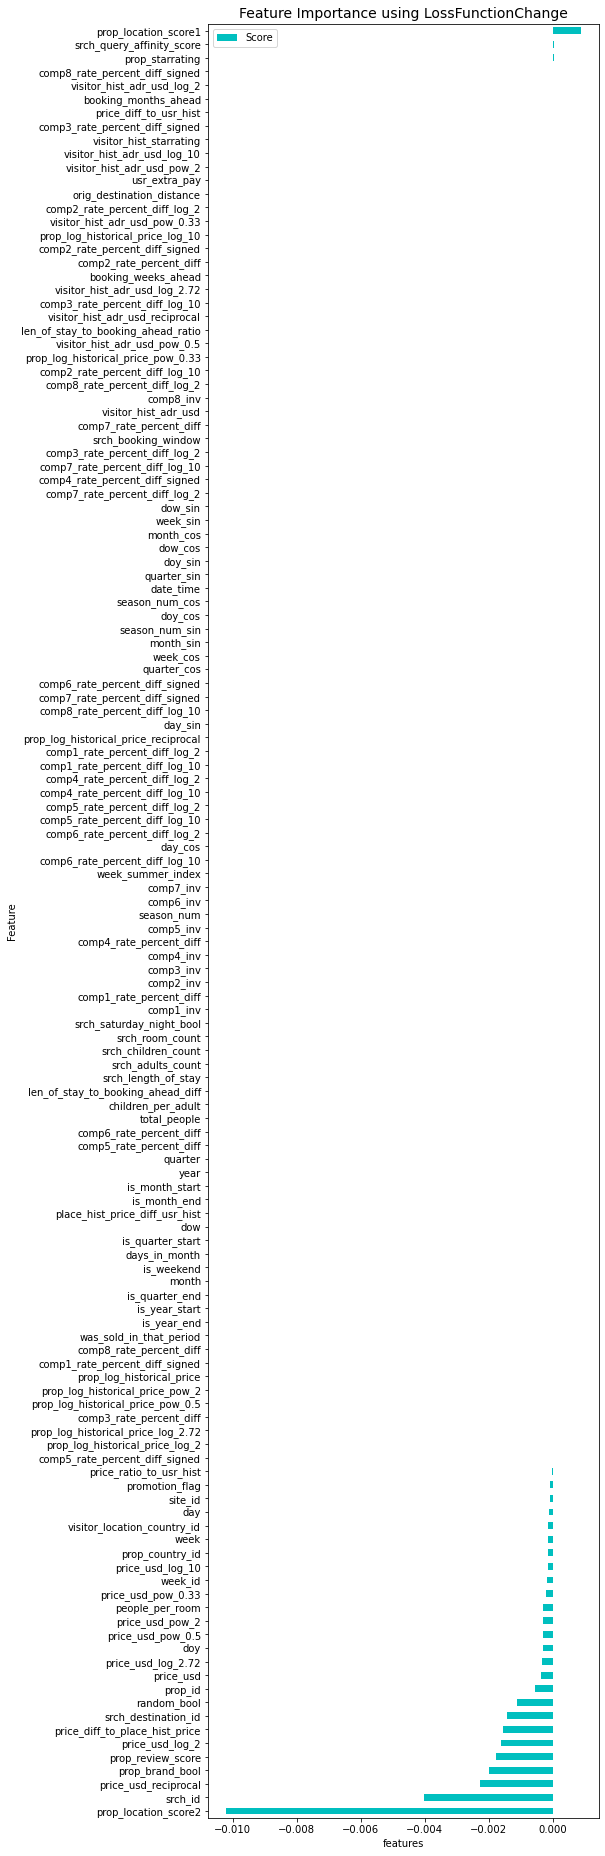

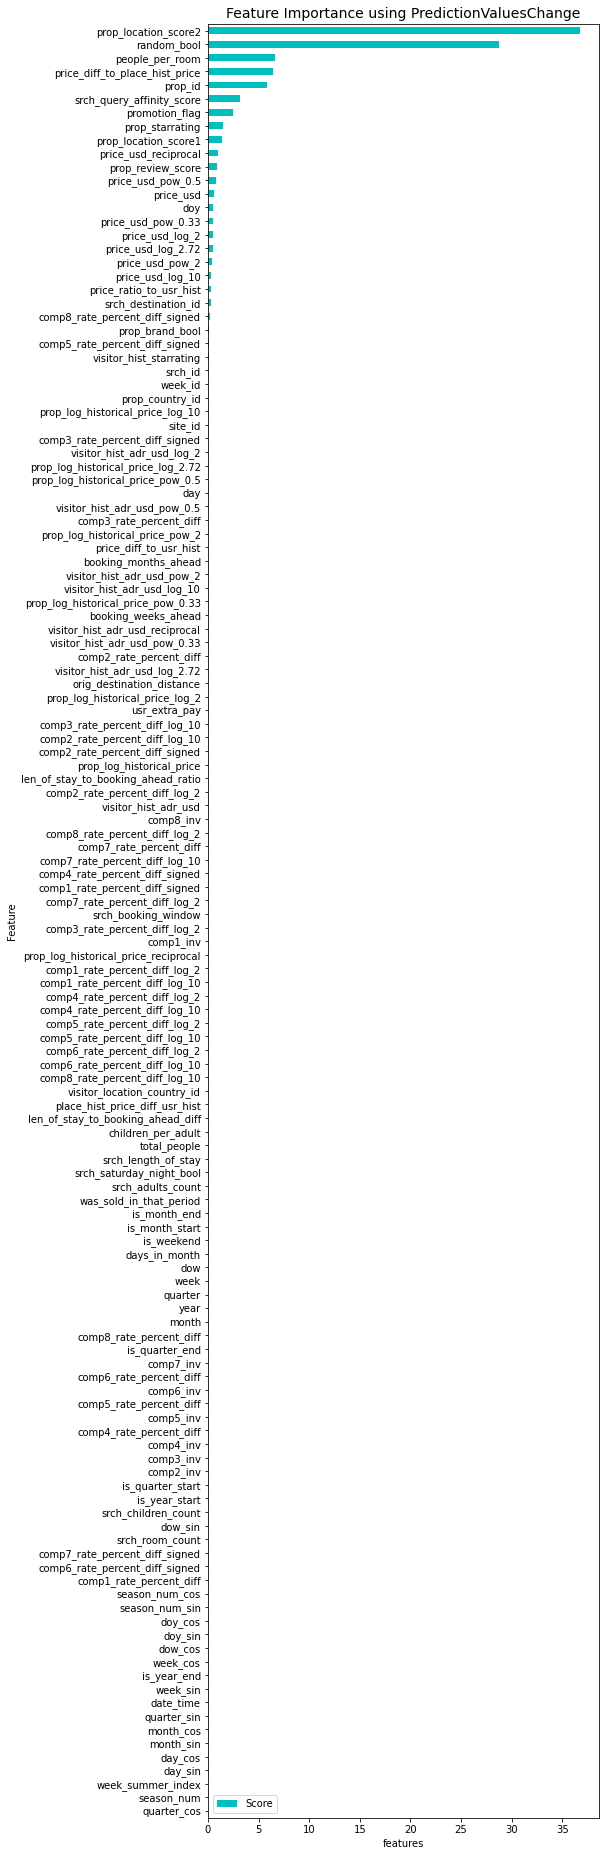

In [132]:
import matplotlib.pyplot as plt

for method in ['LossFunctionChange', 'PredictionValuesChange']:
    fi = model.get_feature_importance(test_pool, type=method)
    feature_score_raw = pd.DataFrame(list(zip(X_test.columns, fi)),
                                     columns=['Feature', 'Score'])

    feature_score = feature_score_raw.sort_values(
        by='Score', ascending=False)

    plt.rcParams["figure.figsize"] = (7, len(feature_score) / 4)
    ax = feature_score.plot('Feature', 'Score', kind='barh', color='c')
    ax.set_title("Feature Importance using {}".format(method), fontsize=14)
    ax.set_xlabel("features")
    ax.invert_yaxis()
    plt.show()

# Make preds

In [133]:
subm_df = pd.read_pickle('data/submission_df_preprocessed.pickle')

In [134]:
subm_df = downcast(subm_df)

In [29]:
# from feature_engine.preprocessing import MatchVariables

# match_columns = MatchVariables()

# match_columns.fit(X_train)

# df_transformed = match_columns.transform(subm_df)

In [136]:
subm_pool = Pool(
    data=subm_df.drop(drop_cols, axis=1),
    group_id=subm_df[group_col],
    cat_features=CAT_FEATURES,
)

subm_pred = model.predict(subm_pool)

output_df = pd.DataFrame({group_col: subm_df[group_col],
                          'prop_id': subm_df['prop_id'],
                          ranking_target+'_pred': subm_pred,
                          })
output_df.sort_values(by=[group_col, ranking_target+'_pred'],
                      ascending=[True, False], inplace=True)
output_df[[group_col, 'prop_id']].to_csv('submission_3.csv', index=False)
output_df.head(10)

,srch_id,prop_id,target_pred
5,1,28181,2.845740
9,1,54937,2.840345
23,1,99484,2.787233
12,1,61934,2.667423
4,1,24194,2.523367
6,1,34263,2.431134
13,1,63894,2.412264
18,1,82231,2.409985
8,1,50162,2.405292
16,1,74045,2.357754


In [137]:
pd.read_csv('submission_3.csv', nrows=10)

,srch_id,prop_id
0,1,28181
1,1,54937
2,1,99484
3,1,61934
4,1,24194
5,1,34263
6,1,63894
7,1,82231
8,1,50162
9,1,74045


Score: 0.36995  
overfit when optimise NDCG.  
finally, the LB really corresponds to the QueryRMSE loss